<a href="https://colab.research.google.com/github/maggiewong8/NYC_restaurant_health_grades_analysis/blob/master/Restaurant_Health_Inspection__Analysis_PYTH122MW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Where in the city has the most sanitary (and not) restaurants?
---

If you've ever walked past a restaurant or your favorite grab and go lunch spot, you've noticed a grade. I want to figure out where in the city has the most violations and where in the city has the cleanest restaurants in nyc.... also, which are potentially the most shocking not clean restuarants. is it your favorite restaurant?

# Content Defined in Analysis 

Files: 

*   DOHMH_New_York_City_Restaurant_Inspection_Results.csv
*   neighborhood_zipcodes.csv


Data : 


*   health_grades
*   health_grades_Y
*   neighborhood_by_zip






In [1]:
#IMPORT LIBRARIES FIRST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

plt.style.use('fivethirtyeight') 

plt.rcParams['figure.figsize'] = (8, 6) 
plt.rcParams['font.size'] = 14

print('done')

done


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls '/content/gdrive/My Drive/Maggie Wong PYTH122'

DOHMH_New_York_City_Restaurant_Inspection_Results.csv
neighborhood_zipcodes.csv


In [4]:
# IMPORT DATASETS FROM GOOGLE DRIVE AND SOME TESTS BELOW
health_grades_orig = pd.read_csv('/content/gdrive/My Drive/Maggie Wong PYTH122/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')
health_grades = health_grades_orig.copy()
neighborhood_by_zip_orig = pd.read_csv('/content/gdrive/My Drive/Maggie Wong PYTH122/neighborhood_zipcodes.csv')
neighborhood_by_zip = neighborhood_by_zip_orig

print('done')

done


In [73]:
#Take a look at the raw restaurant inspection data available from NY Department of Health 
health_grades

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,41650194,LUCEY'S LOUNGE,Brooklyn,475,3 AVENUE,11215.0,7188771075,American,07/22/2017,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,20.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.670716,-73.991622,306.0,39.0,12100.0,3022457.0,3.010150e+09,BK37
1,50006252,DIG INN SEASONAL MARKET,Manhattan,2884,BROADWAY,10025.0,2125457867,American,02/20/2018,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,7.0,A,02/20/2018,01/31/2020,Cycle Inspection / Re-inspection,40.805600,-73.965641,109.0,7.0,19900.0,1056989.0,1.018840e+09,MN09
2,50046623,COLD STONE CREAMERY,Brooklyn,139,FLATBUSH AVE,11217.0,7187892903,"Ice Cream, Gelato, Yogurt, Ices",01/17/2018,Violations were cited in the following area(s).,10H,Proper sanitization not provided for utensil w...,N,45.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.684430,-73.977725,302.0,35.0,3500.0,3348849.0,3.020018e+09,BK68
3,50046957,KATE'S CORNER CAFE,Queens,4125,20TH AVE,11105.0,7189562929,American,07/24/2019,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,17.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.775773,-73.900695,401.0,22.0,12301.0,4015652.0,4.008000e+09,QN72
4,40365166,CORNER BISTRO,Manhattan,331,WEST 4 STREET,10014.0,2122429502,American,12/12/2018,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,20.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.737925,-74.003861,102.0,3.0,7700.0,1011036.0,1.006150e+09,MN23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400371,50037438,MEET THE MEAT,Queens,2392,21ST ST,11105.0,9176743328,Steak,02/09/2018,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Y,32.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.776797,-73.921306,401.0,22.0,9700.0,4437036.0,4.008908e+09,QN72
400372,50081544,GEISHA ASIAN CUISINE & LOUNGE,Manhattan,3470,BROADWAY,10031.0,2128627800,Asian,06/27/2019,Establishment Closed by DOHMH. Violations wer...,04M,Live roaches present in facility's food and/or...,Y,50.0,NaN,NaN,01/31/2020,Cycle Inspection / Re-inspection,40.824232,-73.952038,109.0,7.0,22500.0,1061828.0,1.020730e+09,MN04
400373,40942949,SNACK TAVERNA,Manhattan,63,BEDFORD STREET,10014.0,2129293499,Greek,08/16/2017,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,N,22.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.731074,-74.004683,102.0,3.0,6700.0,1009837.0,1.005840e+09,MN23
400374,50072138,HUI'S GARDEN,Queens,4108,COLLEGE POINT BLVD,11355.0,7188881550,Chinese,10/11/2018,Violations were cited in the following area(s).,06C,Food not protected from potential source of co...,Y,36.0,NaN,NaN,01/31/2020,Cycle Inspection / Initial Inspection,40.756040,-73.833595,407.0,20.0,84900.0,4441757.0,4.050630e+09,QN22


In [5]:
#Data above is missing neighborhood, so below is data mapping zips to neighborhoods
neighborhood_by_zip

,NEIGHBORHOOD,ZIPCODES,Unnamed: 2
0,Central Bronx,"10453, 10457, 10460",NaN
1,Bronx Park and Fordham,"10458, 10467, 10468",NaN
2,High Bridge and Morrisania,"10451, 10452, 10456",NaN
3,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474",NaN
4,Kingsbridge and Riverdale,"10463, 10471",NaN
5,Northeast Bronx,"10466, 10469, 10470, 10475",NaN
6,Southeast Bronx,"10461, 10462,10464, 10465, 10472, 10473",NaN
7,Central Brooklyn,"11212, 11213, 11216, 11233, 11238",NaN
8,Southwest Brooklyn,"11209, 11214, 11228",NaN
9,Borough Park,"11204, 11218, 11219, 11230",NaN


# Let's make this dataset readable and useful for our study. 
We are going to only include critical flag violations, which includes:

*   Food at wrong temp 
*   Not having sink 
*   Vermon (ew)

For more info https://www1.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf

In [0]:
#Remove extra columns
health_grades = health_grades[['DBA', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'INSPECTION DATE', 'CRITICAL FLAG', 'VIOLATION DESCRIPTION' ]]

In [8]:
#Rename DBA to NAME
health_grades.rename(columns={'DBA': 'NAME'}, inplace=True)
health_grades.columns

Index(['NAME', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE',
       'INSPECTION DATE', 'CRITICAL FLAG', 'VIOLATION DESCRIPTION'],
      dtype='object')

# Convert the zipcodess to neighborhoods , so that it's more user friendly

In [0]:
#Convert pandas dataframe neighborhood_by_zip to a dict so that we can add a column of neighborhoods to health_grades
neighborhood_zip_dict = {}

i = 0
for row in neighborhood_by_zip.iterrows():
  data = row[1]
  zipcodes = data["ZIPCODES"].split(',')
  n = data["NEIGHBORHOOD"]
  for zipcode in zipcodes:
    neighborhood_zip_dict[float(zipcode.strip())] = n

In [0]:
#Add a column to health_grades using dict above, account for nans via Not Reported
health_grades['NEIGHBORHOOD'] = health_grades['ZIPCODE'].map(lambda zip_: neighborhood_zip_dict.get(zip_, "Not Reported"))


# Then, let's add a year column, so that we can display trends over the years and break out critical violations vs minor ones

In [0]:
#Use the date column to pull out the year and make it a new column
health_grades['YEAR'] = pd.to_datetime(health_grades['INSPECTION DATE']).dt.year
health_grades = health_grades[['NAME', 'CUISINE DESCRIPTION', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'NEIGHBORHOOD', 'YEAR', 'INSPECTION DATE', 'CRITICAL FLAG', 'VIOLATION DESCRIPTION' ]]


In [0]:
#Break out critical violations from minor ones by defining new data frame 
health_grades_Y = health_grades[health_grades['CRITICAL FLAG'] == 'Y']

# Restaurant Search by ZIP and Name

In [0]:
#USER INPUTS: RESTAURANT NAME AND ZIPCODE
rest_variable = input('name of resturant: ')
rest_variable = rest_variable.upper()

zip_variable = input('zipcode: ')
zip_variable_float = float(zip_variable)

#LOOK UP THE RESTUARANT BY AREA
matches = health_grades["NAME"].str.startswith(rest_variable, na=False) 
health_grades_specific_restaurant = health_grades_Y[matches]

rest_in_zip = health_grades_specific_restaurant[health_grades_specific_restaurant['ZIPCODE'] == zip_variable_float]

rest_in_zip

rest_in_zip['YEAR'].value_counts()
# .plot(kind='bar', x='Year', y='Number of Critial Violations')


# plt.suptitle(rest_variable + ' Critical Violations located in ZIP ' + str(zip_variable))




name of resturant: dig inn
zipcode: 10005


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


ValueError: ignored

#If you want to see what violations they got... run the code below. 
Sorted by most recent violations

In [0]:
rest_in_zip.sort_values(by=['YEAR', 'INSPECTION DATE'] , ascending=[False, False])

,NAME,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,NEIGHBORHOOD,YEAR,INSPECTION DATE,CRITICAL FLAG,VIOLATION DESCRIPTION
209906,DIG INN,American,Manhattan,80,PINE ST,10005.0,Lower Manhattan,2019,10/15/2019,Y,Hot food item not held at or above 140º F.
5536,DIG INN,American,Manhattan,80,PINE ST,10005.0,Lower Manhattan,2019,10/04/2019,Y,"Food contact surface not properly washed, rins..."
168038,DIG INN,American,Manhattan,80,PINE ST,10005.0,Lower Manhattan,2019,10/04/2019,Y,Food not cooled by an approved method whereby ...
203321,DIG INN,American,Manhattan,80,PINE ST,10005.0,Lower Manhattan,2019,10/04/2019,Y,Hot food item not held at or above 140º F.
222772,DIG INN,American,Manhattan,80,PINE ST,10005.0,Lower Manhattan,2019,10/04/2019,Y,Cold food item held above 41º F (smoked fish a...
31243,DIG INN,American,Manhattan,80,PINE ST,10005.0,Lower Manhattan,2019,05/10/2019,Y,Hand washing facility not provided in or near ...
51697,DIG INN,American,Manhattan,80,PINE ST,10005.0,Lower Manhattan,2019,03/20/2019,Y,Cold food item held above 41º F (smoked fish a...
135663,DIG INN,American,Manhattan,80,PINE ST,10005.0,Lower Manhattan,2019,03/20/2019,Y,"Tobacco use, eating, or drinking from open con..."
145653,DIG INN,American,Manhattan,80,PINE ST,10005.0,Lower Manhattan,2018,03/23/2018,Y,Wiping cloths soiled or not stored in sanitizi...
383688,DIG INN,American,Manhattan,80,PINE ST,10005.0,Lower Manhattan,2018,03/23/2018,Y,"Food contact surface not properly washed, rins..."


In [0]:
health_grades_2019_all= health_grades[health_grades['YEAR'] == 2019]
num_of_rest_2019 = health_grades_2019_all[['NAME', 'CUISINE DESCRIPTION', 'NEIGHBORHOOD', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE']]
num_of_rest_2019['combined'] = num_of_rest_2019['NAME'].str.cat(num_of_rest_2019['BUILDING'],sep=" ")
num_of_rest_2019['combined'] = num_of_rest_2019['combined'].str.cat(num_of_rest_2019['STREET'],sep=" ")
num_of_rest_2019 = num_of_rest_2019[['NAME', 'CUISINE DESCRIPTION', 'NEIGHBORHOOD', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE','combined'] ]

num_of_rest_2019.drop_duplicates(subset ="combined", keep = 'first', inplace = True) 

#num_of_rest_2019['NEIGHBORHOOD'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 0.98, 'TOP 10 NEIGHBORHOODS WITH MOST VIOLATIONS IN NYC IN 2019')

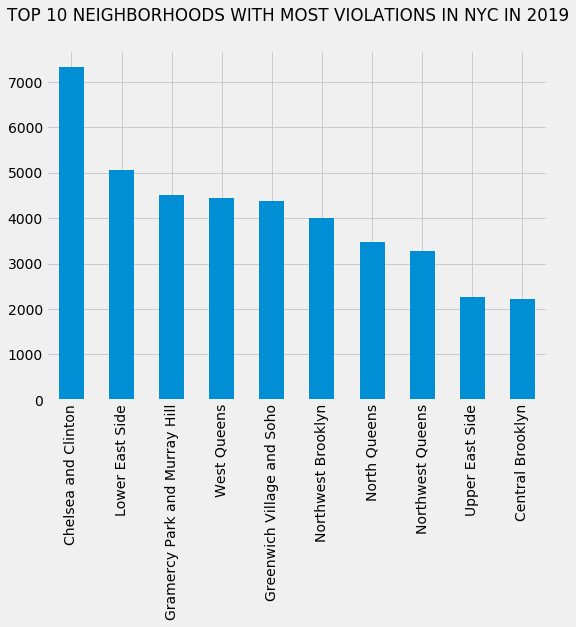

In [0]:
health_grades_2019= health_grades_Y[health_grades_Y['YEAR'] == 2019]

health_grades_2019['NEIGHBORHOOD'].value_counts() 
health_grades_2019['NEIGHBORHOOD'].value_counts().head(10).plot(kind='bar')
plt.suptitle('TOP 10 NEIGHBORHOODS WITH MOST VIOLATIONS IN NYC IN 2019')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Critical Violations')



Text(0.5, 0.98, '10 NYC Neighborhoods with most Restaurants in 2019')

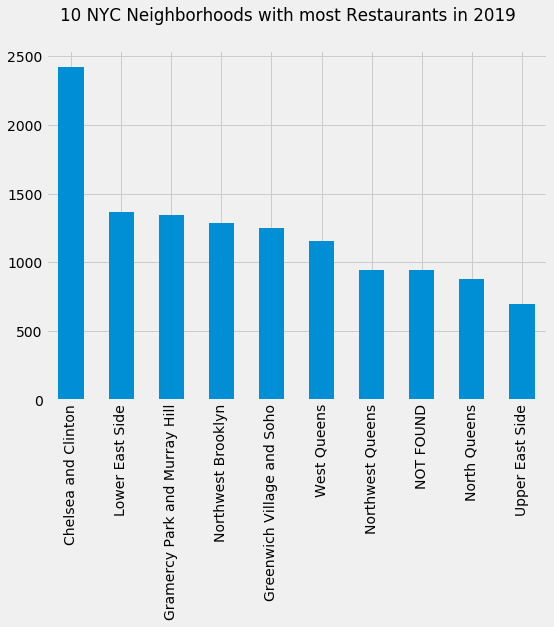

In [0]:
num_of_rest_n = num_of_rest_2019['NEIGHBORHOOD'].value_counts().head(10).plot(kind='bar')
plt.suptitle('10 NYC Neighborhoods with most Restaurants in 2019')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Restaurants')
#check number of restaurants with code below 
#print(num_of_rest_2019['NEIGHBORHOOD'].value_counts().sum())

Text(0.5, 0.98, '10 NYC Neighborhoods with Most Violations in 2019 Nomalized')

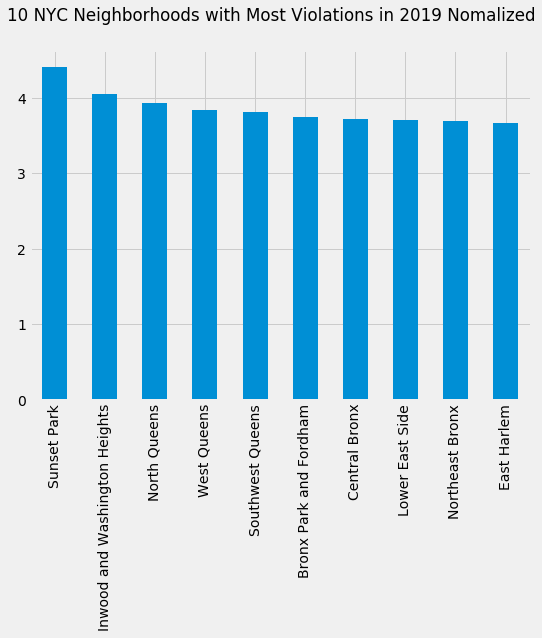

In [0]:
num_of_rest_n = num_of_rest_2019['NEIGHBORHOOD'].value_counts()
num_of_rest_v = health_grades_2019['NEIGHBORHOOD'].value_counts()

violation_per_restaurant = num_of_rest_v.div(num_of_rest_n, level=1, fill_value=0) 
violation_per_restaurant.sort_values(ascending=False).head(10).plot(kind='bar')
plt.suptitle('10 NYC Neighborhoods with Most Violations in 2019 Nomalized')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Violations / Number of Restaurants')

Text(0.5, 0.98, '10 NEIGHBORHOODS WITH LEAST VIOLATIONS IN NYC IN 2019')

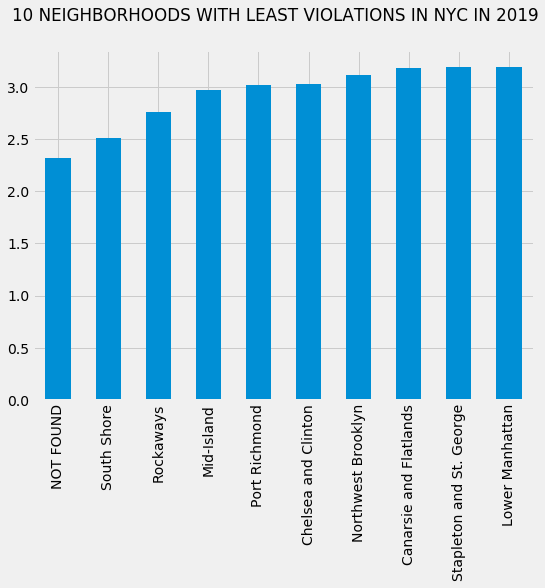

In [0]:
violation_per_restaurant.sort_values(ascending=True).head(10).plot(kind='bar')
plt.suptitle('10 NEIGHBORHOODS WITH LEAST VIOLATIONS IN NYC IN 2019')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Violations / Number of Restaurants')



Text(0.5, 0.98, 'CUSINES WITH MOST VIOLATIONS IN NYC IN 2019')

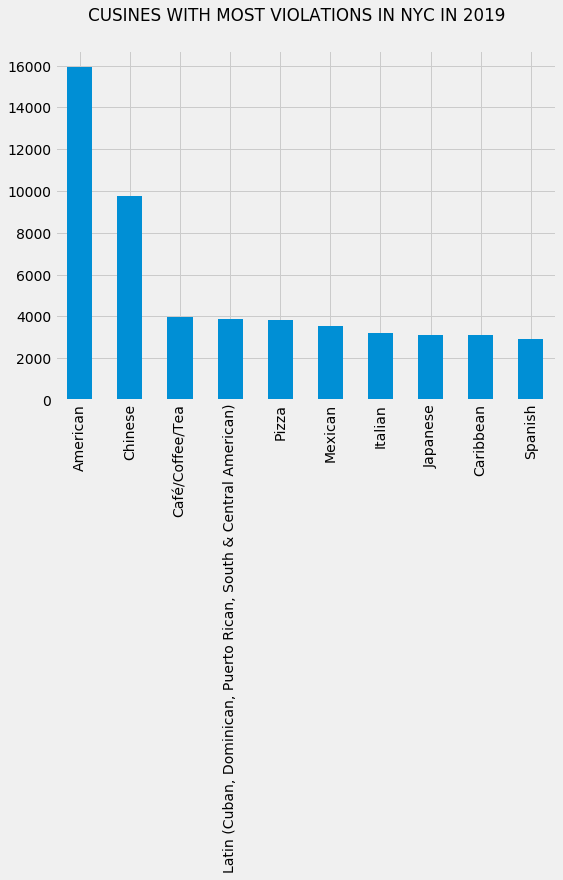

In [0]:
health_grades_2019['CUISINE DESCRIPTION'].value_counts().head(10).plot(kind='bar')
plt.suptitle('CUSINES WITH MOST VIOLATIONS IN NYC IN 2019')